In [1]:
# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd # data wrangling
import seaborn as sns # data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# For handling multiple files
from glob import glob

# for cat features
from category_encoders import OneHotEncoder

# For interactive dashboard
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

from sklearn.impute import SimpleImputer # Handling missing values
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action="ignore", category=Warning)

In [2]:
df = pd.read_csv('../data/smallsales.csv')

Feature Engineering

Text(0.5, 1.0, 'Boxplot: Views')

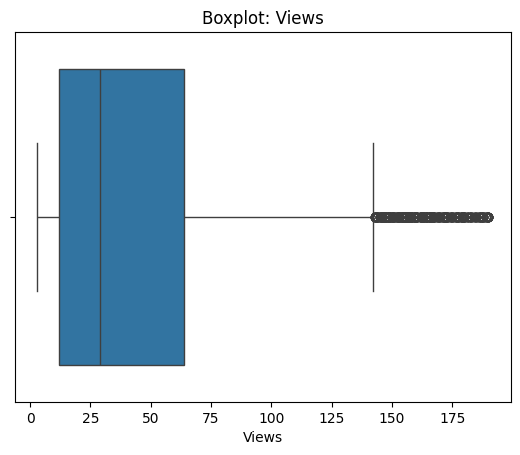

In [3]:
df = df.loc[df["price_cost"]!=0] #Clears redundant data

#df = df.fillna(0) #Fills empty values


low, high = df['views'].quantile([0.1, 0.95])    #Removing Outliers
mask_area = df['views'].between(low, high)

df = df[mask_area]
sns.boxplot(df, x="views", orient="h")
plt.xlabel("Views")
plt.title("Boxplot: Views")

In [4]:
df.isnull().sum()/len(df)*100 #Checks for high null percentages

date            0.0
id              0.0
category_id     0.0
sales           0.0
views           0.0
price_cost      0.0
price_retail    0.0
dtype: float64

In [5]:
feature_cardinality = df.select_dtypes("object").nunique #Checks for high and low cardinality objects
feature_cardinality

<bound method DataFrame.nunique of              date
403    2023-04-03
404    2023-04-04
405    2023-04-05
406    2023-04-06
407    2023-04-07
...           ...
18295  2024-02-21
18296  2024-02-22
18297  2024-02-23
18298  2024-02-24
18299  2024-02-25

[10395 rows x 1 columns]>

In [6]:
df.head() #checks for leaky features
# No leaky features

,date,id,category_id,sales,views,price_cost,price_retail
403,2023-04-03,1,3,0,29,1450,1885
404,2023-04-04,1,3,0,45,1450,1885
405,2023-04-05,1,3,0,28,1450,1885
406,2023-04-06,1,3,0,42,1450,1885
407,2023-04-07,1,3,0,39,1450,1885


In [7]:
corr_df = df.select_dtypes("number").corr() #Checks for collinearity
corr_df


,id,category_id,sales,views,price_cost,price_retail
id,1.000000,-0.165966,-0.013597,0.048948,-0.262141,-0.255249
category_id,-0.165966,1.000000,0.160374,0.215824,-0.634000,-0.622097
sales,-0.013597,0.160374,1.000000,0.231416,-0.158473,-0.155753
views,0.048948,0.215824,0.231416,1.000000,-0.281707,-0.281868
price_cost,-0.262141,-0.634000,-0.158473,-0.281707,1.000000,0.989221
price_retail,-0.255249,-0.622097,-0.155753,-0.281868,0.989221,1.000000


In [8]:
fig = px.imshow(corr_df, color_continuous_scale='Spectral')
fig.update_layout(title='Heat Map: Correlation of Features', font=dict(size=12))
fig.show() #Draws a map of correlation

In [9]:
#df = df.drop(columns=["id","price_cost"], inplace= True) #Drops high correlating columns
df.head()

,date,id,category_id,sales,views,price_cost,price_retail
403,2023-04-03,1,3,0,29,1450,1885
404,2023-04-04,1,3,0,45,1450,1885
405,2023-04-05,1,3,0,28,1450,1885
406,2023-04-06,1,3,0,42,1450,1885
407,2023-04-07,1,3,0,39,1450,1885


Model Building

In [10]:
# Separate features from the target.
target = "sales"
features =["date","category_id","views","price_retail"]
X = df[features] # dataframe
y = df[target] # series

y

403      0
404      0
405      0
406      0
407      0
        ..
18295    0
18296    0
18297    0
18298    0
18299    0
Name: sales, Length: 10395, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

# split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
y_mean = (y_train.mean())

y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt sales: ",round(y_mean, 2))

print("Baseline MAE: ", round(mean_absolute_error(y_train,y_pred_baseline),2))

Mean apt sales:  1.14
Baseline MAE:  1.98


In [13]:
model_lr = make_pipeline(

    OneHotEncoder(use_cat_names=True), # encode cat features
    SimpleImputer(), # imputation
    LinearRegression()) # build model

# fit the model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['date'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [14]:
# Predict the train data
y_pred_training = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 2.52
Test data MAE: 2.9


In [15]:
rf = make_pipeline(

    # encode cat features
    OneHotEncoder(use_cat_names=True),

    # Imputation
    SimpleImputer(),

    # build model
    RandomForestRegressor(
        random_state=42)
    )

# fit the model
rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['date'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [16]:
# Predict the train data
y_pred_training = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Compute MAE
print(f"Training MAE:{round(mean_absolute_error(y_train, y_pred_training),2)}")
print(f"Test data MAE:{round(mean_absolute_error(y_test, y_pred_test),2)}")

Training MAE:0.45
Test data MAE:1.41


In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score

params = {
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
}
params

{'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

In [18]:
[i for i in range(10, 50, 10)]
[j for j in range(25, 100, 25)]

[25, 50, 75]

In [19]:
model = GridSearchCV(
    rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['date'],
                                                      use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25)},
             verbose=1)

In [21]:
cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
cv_results = pd.DataFrame(model.cv_results_)
model.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 25}

In [22]:
y_pred_training = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 1.14
Test data MAE: 1.6


In [24]:
import joblib
# Save Model
joblib.dump(model, '../artifacts/model_2.pkl')

# Loading Model
model = joblib.load('../artifacts/model_2.pkl')

# Make predictions
model.predict(X)


array([0.44704899, 0.44704899, 0.44704899, ..., 0.06806856, 0.04354454,
       0.03857729])

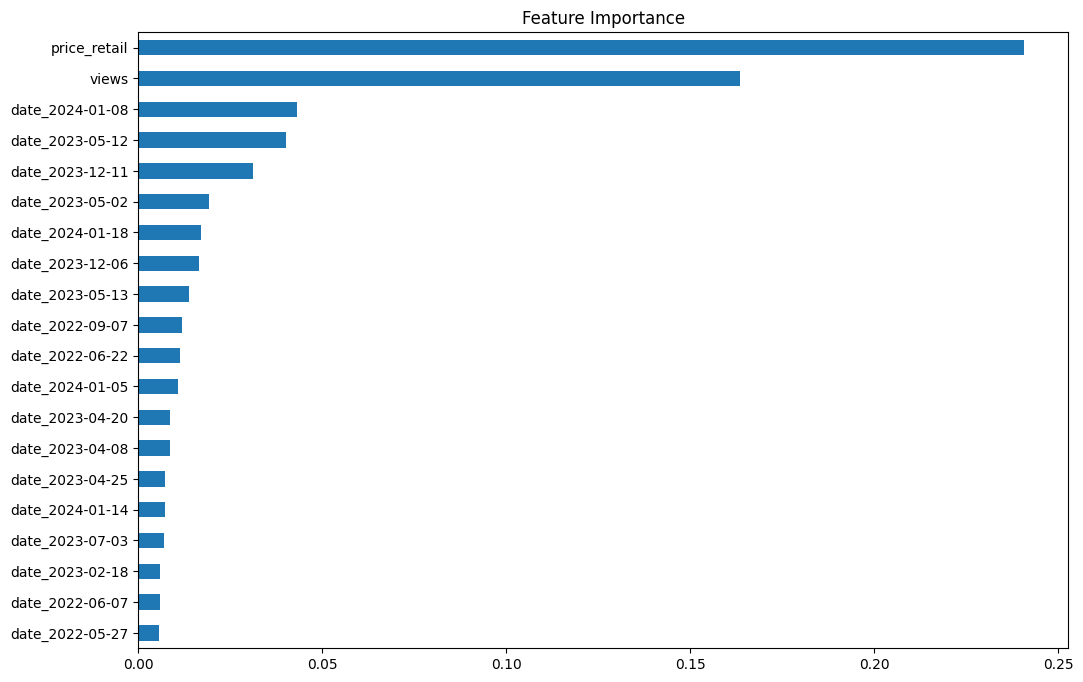

In [25]:
# Get coefficients of features
coefficients = rf.named_steps.randomforestregressor.feature_importances_

# Get feature names
features = rf.named_steps["onehotencoder"].get_feature_names()

# Create a Series of features
feat_imp = pd.Series(data=coefficients, index=features)

plot_feat_imp = feat_imp.sort_values(ascending=True).tail(20)
plot_feat_imp.plot(kind="barh", figsize=(12,8))
plt.title("Feature Importance")
plt.show()

In [26]:
def make_prediction(date, category_id, views, price_retail):

    # Load the model
#     model = joblib.load(model_name)

    # Creating a dictionary for the new data
    data = {
        "date": date,
        "category_id": category_id,
        "views": views,
        "price_retail": price_retail
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(0)[0]
    return f"Predicted sales: {prediction}"

In [27]:
make_prediction("2023-01-18",3,50,20000)

'Predicted sales: 0.0'